In [90]:
import requests 
import polars as pl
import time
from typing import Optional

In [ ]:
https://api.elections.kalshi.com/trade-api/v2/series

In [2]:

url = "https://api.elections.kalshi.com/trade-api/v2/series"

querystring = {"category":"Elections"}

response = requests.get(url, params=querystring)



In [9]:
df = pl.DataFrame(response.json()['series'])

In [10]:
df['ticker']

ticker
str
"""KXDEMMIDTERMSSEATS"""
"""KXELECTIONMOVIRELAND"""
"""KXATTYGENPA"""
"""KXVOTEPERCENTPVV"""
"""KXDECLAREPRESFIRSTD"""
…
"""KXNORWAYPROGRESS"""
"""KXATTYGENNC"""
"""KXJAPANHOC2ND"""


In [ ]:
BASE_URL = 'https://api.elections.kalshi.com/trade-api/v2'

class KalshiClient:
    def __init__(self, max_retries=5, min_delay=.2):
        self.max_retries = max_retries
        self.min_delay = min_delay
        self.last_request_time = 0
        
        
    def _respect_spacing(self):
        """Ensure at least min_delay between requests."""
        elapsed = time.time() - self.last_request_time
        if elapsed < self.min_delay:
            time.sleep(self.min_delay - elapsed)
            
            
    def _request(self, endpoint: str, params: Optional[dict] = None):
        url = f"{BASE_URL}{endpoint}"

        for attempt in range(self.max_retries):
            self._respect_spacing()

            response = requests.get(url, params=params)
            self.last_request_time = time.time()

            # Successful
            if response.status_code == 200:
                return response.json()

            # Rate limited
            if response.status_code == 429:
                retry_after = response.headers.get("Retry-After")

                if retry_after:
                    wait = float(retry_after)
                else:
                    # exponential backoff: 0.5, 1, 2, 4, ...
                    wait = 0.5 * (2 ** attempt)

                print(f"Rate limited (429). Waiting {wait:.2f}s...")
                time.sleep(wait)
                continue

            # Other errors
            response.raise_for_status()

        raise Exception("Max retries exceeded.")
        
    
    def fetch_paginated(self, endpoint, params=None, delay=0.15):
        base_params = params or {}
        limit = base_params.get("limit", 500)
        cursor = None

        while True:
            query = dict(base_params)
            if cursor:
                query["cursor"] = cursor

            response = requests.get(f"{BASE_URL}{endpoint}", params=query)
            response.raise_for_status()
            data = response.json()

            yield data

            # Retrieve cursor if present
            cursor = data.get("cursor")

            # If cursor is empty but page is full, assume next page exists
            trades = data.get("trades", [])

            if not cursor and len(trades) < limit:
                break

            if cursor is None:
                break

            time.sleep(delay)



    # ----------- PUBLIC API METHODS -----------

    def list_markets(self):
        return self._request("/markets")

    def get_market(self, ticker: str):
        return self._request(f"/markets/{ticker}")

    def list_events(self):
        return self._request("/events")

    def get_event(self, event_id: str):
        return self._request(f"/events/{event_id}")
    
    def fetch_all_trades(self, ticker):
        trades = []
        for page in self.fetch_paginated(f"/markets/trades", {'limit':1000,'ticker':ticker}):
            trades.extend(page.get("trades", []))
        return trades

In [40]:
def get_all_series(s_ticker):
    url = "https://api.elections.kalshi.com/trade-api/v2/markets"

    querystring = {"limit":"999","series_ticker":s_ticker}

    response = requests.get(url, params=querystring)

    return(response.json()['markets'])

In [41]:
dfs =[]

for i in df['ticker']:
    dfs.append(pl.DataFrame(get_all_series(i),strict=False))
    
    
    

In [79]:
filtered_dfs = [df.select('ticker', 'volume', 'settlement_value', 'status') for df in dfs if df[0].shape[1] == 54]

In [82]:
markets = pl.concat(filtered_dfs)

In [87]:
markets = markets.filter(pl.col('volume') > 100)

In [88]:
markets

ticker,volume,settlement_value,status
str,i64,i64,str
"""KXELECTIONMOVIRELAND-25OCT24-P…",131,0,"""finalized"""
"""KXELECTIONMOVIRELAND-25OCT24-P…",2929,100,"""finalized"""
"""KXELECTIONMOVIRELAND-25OCT24-P…",3239,0,"""finalized"""
"""KXELECTIONMOVIRELAND-25OCT24-P…",2411,0,"""finalized"""
"""KXELECTIONMOVIRELAND-25OCT24-P…",2059,0,"""finalized"""
…,…,…,…
"""KXCDUPERCENT-25-22.45""",6370,0,"""finalized"""
"""KXMOLDOVAPAS-25SEP28-B31""",2578,0,"""finalized"""
"""KXMOLDOVAPAS-25SEP28-51-60""",118,100,"""finalized"""


In [185]:
client = KalshiClient()

In [186]:
from tqdm import tqdm
import polars as pl

trades = []

for ticker in tqdm(markets['ticker'], desc="Downloading trades"):

    try:
        data = client.fetch_all_trades(ticker)
        trades.append(pl.DataFrame(data, strict=False))
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

In [187]:
trades = [df.unnest('trades') for df in trades]

ColumnNotFoundError: "trades" not found

In [146]:
trades[0].shape

IndexError: list index out of range

In [192]:
trade_dfs = [df for df in trades if df.shape[0] > 500]

In [193]:
trade_df = pl.concat(trade_dfs)

In [196]:
trade_df.join(markets, on='ticker')

count,created_time,no_price,no_price_dollars,price,taker_side,ticker,trade_id,yes_price,yes_price_dollars,volume,settlement_value,status
i64,str,i64,str,f64,str,str,str,i64,str,i64,i64,str
5,"""2025-02-23T23:05:54.392803Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""18409088-460a-4b45-a0bf-a91b5a…",99,"""0.9900""",21103,100,"""finalized"""
25,"""2025-02-23T21:16:29.248296Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""01752953-f9da-480f-8976-1792d4…",99,"""0.9900""",21103,100,"""finalized"""
470,"""2025-02-23T21:08:53.212869Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""87df6e39-12a8-453e-b3f4-4aa5d4…",99,"""0.9900""",21103,100,"""finalized"""
50,"""2025-02-23T18:28:51.675307Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""49a99f80-e3ff-429e-b817-67c415…",99,"""0.9900""",21103,100,"""finalized"""
348,"""2025-02-23T17:43:41.41342Z""",6,"""0.0600""",0.94,"""yes""","""KXSPDPERCENT-25-17.45""","""5e64e796-5849-452d-b7aa-bf389f…",94,"""0.9400""",21103,100,"""finalized"""
…,…,…,…,…,…,…,…,…,…,…,…,…
73,"""2025-09-11T19:27:59.385288Z""",86,"""0.8600""",0.14,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""31741ca0-082d-49c9-8230-fe1ffd…",14,"""0.1400""",75184,100,"""finalized"""
85,"""2025-09-11T19:27:24.241001Z""",88,"""0.8800""",0.12,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""b20d214b-8677-45f0-a276-751769…",12,"""0.1200""",75184,100,"""finalized"""
100,"""2025-09-11T19:27:24.241001Z""",89,"""0.8900""",0.11,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""a723149a-7e6d-474e-b8e8-7a3a99…",11,"""0.1100""",75184,100,"""finalized"""


In [204]:
import polars as pl
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
def prepare_ts(df):
    return (
        df
        .with_columns([
            pl.col("created_time").str.strptime(pl.Datetime),
            (pl.col("yes_price") / 100).alias("p"),
        ])
        .sort("created_time")
        .with_columns([
            pl.col("p").map_elements(lambda p: np.log(p/(1-p)) if p>0 and p<1 else None).alias("x")
        ])
        .drop_nulls(["x"])   # remove bad prices (0 or 1)
    )


def horizon_regression(ts, horizon):
    df = (
        ts
        .with_columns([
            pl.col("p").shift(-horizon).alias("p_fut")
        ])
        .drop_nulls(["p_fut"])
    )

    p = df["p"].to_numpy()
    p_fut = df["p_fut"].to_numpy()

    β = np.polyfit(p, p_fut, 1)[0]
    return β


def return_series(ts, horizon):
    return (
        ts
        .with_columns(pl.col("x").shift(-horizon).alias("x_fut"))
        .drop_nulls()
        .with_columns((pl.col("x_fut") - pl.col("x")).alias("r"))
    )["r"].to_numpy()

def ljung(ts, horizon):
    r = return_series(ts, horizon)
    return acorr_ljungbox(r, lags=[10], return_df=True)


def variance_scaling(ts, horizons=[1,3,7,14,30]):
    out = []
    for H in horizons:
        r = return_series(ts, H)
        out.append((H, np.var(r)))
    return out


def hitting_times(ts, up=0.2, down=-0.2):
    xs = ts["x"].to_numpy()
    hits = []
    for i in range(len(xs)):
        x0 = xs[i]
        for j in range(i+1, len(xs)):
            dx = xs[j] - x0
            if dx >= up or dx <= down:
                hits.append(xs[j] - x0)
                break
    return np.mean(hits)



def taleb_backtest(ts, buy_thresh=0.05, exit_gain=0.20, stop_loss=0.01, fee=0.002):
    cash = 0
    pos = 0
    entry_price = None

    p = ts["p"].to_numpy()

    for price in p:
        # enter
        if pos == 0 and price <= buy_thresh:
            pos = 1
            entry_price = price * (1+fee)

        # exit gain
        elif pos == 1 and price >= exit_gain:
            cash += (price - entry_price) - fee*price
            pos = 0

        # stop loss
        elif pos == 1 and price <= stop_loss:
            cash += (price - entry_price) - fee*price
            pos = 0

    return cash





C:\Users\mhbvp41\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [205]:
tickers = trade_df["ticker"].unique().to_list()

results = {}

for t in tickers:
    ts = prepare_ts(trade_df.filter(pl.col("ticker")==t))
    
    res = {
        "beta": {H: horizon_regression(ts, H) for H in [1,3,7]},
        "ljung": {H: ljung(ts, H) for H in [1,3,7]},
        "variance": variance_scaling(ts),
        "optional_sampling_mean": hitting_times(ts),
        "taleb_pnl": taleb_backtest(ts),
    }
    
    results[t] = res

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27032\1223904449.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df
C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27032\1223904449.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df
C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27032\1223904449.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df
C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27032\1223904449.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df
C:\Users\mhbvp41

In [211]:
def run_all_tests(df):

    tickers = df["ticker"].unique().to_list()
    rows = []

    for t in tickers:
        ts = prepare_ts(df.filter(pl.col("ticker") == t))
        if ts.height < 20:
            continue

        row = {
            "ticker": t,

            # horizon regression slopes
            "beta_1": horizon_beta(ts, 1),
            "beta_3": horizon_beta(ts, 3),
            "beta_7": horizon_beta(ts, 7),

            # Ljung-Box p-values
            "ljung_1": ljung_pvalue(ts, 1),
            "ljung_3": ljung_pvalue(ts, 3),
            "ljung_7": ljung_pvalue(ts, 7),

            # variance scaling
            "var_1": variance(ts, 1),
            "var_3": variance(ts, 3),
            "var_7": variance(ts, 7),

            # optional sampling
            "optional_sampling_mean": hitting_times(ts),

            # taleb pnl
            "taleb_pnl": taleb_backtest(ts),
        }

        rows.append(row)

    return pl.DataFrame(rows)

In [212]:
run_all_tests(trade_df)

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27032\1223904449.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df


NameError: name 'horizon_beta' is not defined

In [985]:
import polars as pl
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox


# -------------------------------------------------------------------
# 1. PREPARE TIME SERIES
# -------------------------------------------------------------------
def prepare_ts(df):
    return (
        df
        .with_columns([
            pl.col("created_time").str.strptime(pl.Datetime),
            (pl.col("yes_price") / 100).alias("p"),
        ])
        .sort("created_time")
        .with_columns([
            pl.col("p").map_elements(lambda p: np.log(p/(1-p)) if 0 < p < 1 else None).alias("x")
        ])
        .drop_nulls(["x"])
    )


# -------------------------------------------------------------------
# 2. HORIZON REGRESSION β ≈ 1?
# -------------------------------------------------------------------
def horizon_beta(ts, horizon):
    df = (
        ts
        .with_columns(pl.col("p").shift(-horizon).alias("p_fut"))
        .drop_nulls(["p_fut"])
    )
    if df.height < 3:
        return None

    p = df["p"].to_numpy()
    p_fut = df["p_fut"].to_numpy()

    β = np.polyfit(p, p_fut, 1)[0]
    return float(β)


# -------------------------------------------------------------------
# 3. RETURNS, VARIANCE, AUTOCORR, LJUNG-BOX
# -------------------------------------------------------------------
def horizon_returns(ts, horizon):
    df = (
        ts
        .with_columns(pl.col("x").shift(-horizon).alias("x_fut"))
        .drop_nulls()
        .with_columns((pl.col("x_fut") - pl.col("x")).alias("r"))
    )
    return df["r"].to_numpy()


def ljung_pvalue(ts, horizon):
    r = horizon_returns(ts, horizon)
    if len(r) < 20:
        return None
    return float(acorr_ljungbox(r, lags=[10], return_df=True)["lb_pvalue"].iloc[0])


def variance(ts, horizon):
    r = horizon_returns(ts, horizon)
    if len(r) < 3:
        return None
    return float(np.var(r))


# -------------------------------------------------------------------
# 4. OPTIONAL-SAMPLING (HITTING TIME EXPECTED VALUE)
# -------------------------------------------------------------------
def hitting_times(ts, up=0.2, down=-0.2):
    xs = ts["x"].to_numpy()
    out = []
    N = len(xs)

    for i in range(N):
        x0 = xs[i]
        for j in range(i+1, N):
            dx = xs[j] - x0
            if dx >= up or dx <= down:
                out.append(dx)
                break

    if len(out) == 0:
        return None
    return float(np.mean(out))


# -------------------------------------------------------------------
# 5. TALEB-STYLE CONVEXITY BACKTEST
# -------------------------------------------------------------------
def taleb_backtest_realistic(
    ts,
    vol_window=100,         # rolling vol window for local sigma
    k=3.0,                  # number of σ-jumps needed to trigger
    bankroll=10_000,
    risk_fraction=0.01,     # risk 1% of bankroll *max*
    max_position=500,       # cap position size (capacity constraint)
    max_holding=50,         # cap holding period (no infinite holds)
    spread=0.002,           # 0.2% round-trip cost modeling
    slippage=0.001,         # price impact on entry/exit
    take_profit_frac=0.50,  # revert 50% toward prior price
    stop_loss_frac=1.00,    # stop out if full jump continues
):
    """
    A realistic convexity-arbitrage backtest designed for low-tick, illiquid,
    jumpy markets (prediction markets, small tokens, micro-futures, etc.).
    """

    p = ts["price"].to_numpy()
    n = len(p)

    if n < vol_window + 5:
        return {"pnl": 0, "sharpe":0, "trades":0}

    # --- rolling realized volatility ---
    returns = np.diff(np.log(p))
    rolling_sigma = pd.Series(returns).rolling(vol_window).std().to_numpy()
    rolling_sigma = np.concatenate([[np.nan]*(vol_window+1), rolling_sigma[vol_window:]])

    pnl_daily = []      # daily PnL series for true Sharpe
    current_pnl = 0
    in_position = False

    entry_price = None
    direction = 0
    entry_index = None
    size = 0

    for t in range(1, n):
        pt = p[t]
        prev = p[t-1]

        # append daily pnl at day boundaries (or each tick if intraday)
        pnl_daily.append(current_pnl)
        current_pnl = 0

        sigma = rolling_sigma[t]
        if np.isnan(sigma) or sigma < 1e-8:
            continue

        dpt = pt - prev

        # -------------------------------------
        # ENTRY SIGNAL (JUMP RELATIVE TO LOCAL VOL)
        # -------------------------------------
        if not in_position:
            jump_thresh = k * sigma

            if abs(dpt) > jump_thresh:
                # mean revert: jump up → short ; jump down → long
                direction = -np.sign(dpt)
                entry_price = pt + slippage * direction  # pay slippage
                entry_index = t

                # realistic target / stop
                target = prev + take_profit_frac * dpt
                stop   = prev + stop_loss_frac  * dpt

                # risk = distance to stop
                est_risk = abs(stop - entry_price)
                max_risk = bankroll * risk_fraction

                if est_risk < 1e-6:
                    continue

                size = int(max_risk / est_risk)
                size = min(size, max_position)  # capacity constraint

                if size < 1:
                    continue

                in_position = True
                continue

        # -------------------------------------
        # EXIT LOGIC
        # -------------------------------------
        if in_position:

            # detect target / stop
            hit_target = (direction == +1 and pt >= target) or \
                         (direction == -1 and pt <= target)

            hit_stop   = (direction == +1 and pt <= stop) or \
                         (direction == -1 and pt >= stop)

            # time stop
            time_expired = (t - entry_index) > max_holding

            if hit_target or hit_stop or time_expired:

                exit_price = pt - slippage * direction
                raw_pnl = (exit_price - entry_price) * direction * size
                cost = spread * pt * size

                trade_pnl = raw_pnl - cost
                current_pnl += trade_pnl

                in_position = False

    # -------------------------------------
    # FINAL SHARPE
    # -------------------------------------
    pnl_arr = np.array(pnl_daily)
    mean = pnl_arr.mean()
    std  = pnl_arr.std() + 1e-9
    sharpe = mean / std * np.sqrt(252)

    return {
        "pnl": pnl_arr.sum(),
        "sharpe": sharpe,
        "trades": len(pnl_arr[pnl_arr != 0]),
    }
    
    
def mid_backtest(
    ts,
    bankroll=10_000,
    risk_fraction=0.1,     # risk 1% of bankroll *max*
    max_position=500,       # cap position size
    max_holding=500,         # max holding period
    spread=0.002,           # round-trip cost
    slippage=0.001,         # price impact
    take_profit_frac=0.3,  # 5% move in favorable direction
    stop_loss_frac=0.3     # 5% move against position
):
    """
    Range-based convexity-arbitrage backtest:
    - Buy if price in [0.45, 0.55]
    - Short if price in [0.60, 0.70]
    """

    p = ts["price"].to_numpy()
    n = len(p)
    if n < 5:
        return {"pnl": 0, "sharpe": 0, "trades": 0}

    pnl_daily = []
    current_pnl = 0
    in_position = False
    entry_price = None
    direction = 0
    entry_index = None
    size = 0

    for t in range(1, n):
        pt = p[t]

        # daily PnL aggregation
        pnl_daily.append(current_pnl)
        current_pnl = 0

        # -------------------------------------
        # ENTRY SIGNALS
        # -------------------------------------
        if not in_position:
            if 0.45 <= pt <= 0.55:
                direction = +1  # long
            elif 0.60 <= pt <= 0.75:
                direction = -1  # short
            else:
                continue

            entry_price = pt + slippage * direction
            entry_index = t

            # risk-based position sizing
            est_risk = entry_price * stop_loss_frac
            max_risk = bankroll * risk_fraction
            size = int(max_risk / est_risk)
            size = min(size, max_position)
            if size < 1:
                continue

            # target & stop
            target = entry_price * (1 + direction * take_profit_frac)
            stop   = entry_price * (1 - direction * stop_loss_frac)

            in_position = True
            continue

        # -------------------------------------
        # EXIT LOGIC
        # -------------------------------------
        if in_position:
            hit_target = (direction == +1 and pt >= target) or \
                         (direction == -1 and pt <= target)
            hit_stop   = (direction == +1 and pt <= stop) or \
                         (direction == -1 and pt >= stop)
            time_expired = (t - entry_index) > max_holding

            if hit_target or hit_stop or time_expired:
                exit_price = pt - slippage * direction
                raw_pnl = (exit_price - entry_price) * direction * size
                cost = spread * pt * size
                trade_pnl = raw_pnl - cost
                current_pnl += trade_pnl

                in_position = False

    # -------------------------------------
    # FINAL SHARPE
    # -------------------------------------
    pnl_arr = np.array(pnl_daily)
    mean = pnl_arr.mean()
    std = pnl_arr.std() + 1e-9
    sharpe = mean / std * np.sqrt(252)

    return {
        "pnl": pnl_arr.sum(),
        "sharpe": sharpe,
        "trades": len(pnl_arr[pnl_arr != 0]),
    }


# -------------------------------------------------------------------
# 6. MAIN FUNCTION: RUN ALL TESTS FOR ALL TICKERS → POLARS DATAFRAME
# -------------------------------------------------------------------
def run_all_tests(df):

    tickers = df["ticker"].unique().to_list()
    rows = []

    for t in tickers:
        ts = prepare_ts(df.filter(pl.col("ticker") == t))
        if ts.height < 20:
            continue
        output = mid_backtest(ts)
        row = {
            "ticker": t,

            # horizon regression slopes
            "beta_1": horizon_beta(ts, 1),
            "beta_3": horizon_beta(ts, 50),
            "beta_7": horizon_beta(ts,500),

            # Ljung-Box p-values
            "ljung_1": ljung_pvalue(ts, 1),
            "ljung_3": ljung_pvalue(ts, 50),
            "ljung_7": ljung_pvalue(ts, 500),

            # variance scaling
            "var_1": variance(ts, 1),
            "var_3": variance(ts, 500),
            "var_7": variance(ts, 500),

            # optional sampling
            "optional_sampling_mean": hitting_times(ts),

            "taleb_pnl": output['pnl'],
            "taleb_sharpe": output['sharpe'],
            "trades": output['trades']
        }

        rows.append(row)

    return pl.DataFrame(rows)


In [986]:
import warnings
from polars.exceptions import MapWithoutReturnDtypeWarning

warnings.filterwarnings("ignore", category=MapWithoutReturnDtypeWarning)

In [987]:
trade_df

count,created_time,no_price,no_price_dollars,price,taker_side,ticker,trade_id,yes_price,yes_price_dollars
i64,str,i64,str,f64,str,str,str,i64,str
5,"""2025-02-23T23:05:54.392803Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""18409088-460a-4b45-a0bf-a91b5a…",99,"""0.9900"""
25,"""2025-02-23T21:16:29.248296Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""01752953-f9da-480f-8976-1792d4…",99,"""0.9900"""
470,"""2025-02-23T21:08:53.212869Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""87df6e39-12a8-453e-b3f4-4aa5d4…",99,"""0.9900"""
50,"""2025-02-23T18:28:51.675307Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""49a99f80-e3ff-429e-b817-67c415…",99,"""0.9900"""
348,"""2025-02-23T17:43:41.41342Z""",6,"""0.0600""",0.94,"""yes""","""KXSPDPERCENT-25-17.45""","""5e64e796-5849-452d-b7aa-bf389f…",94,"""0.9400"""
…,…,…,…,…,…,…,…,…,…
73,"""2025-09-11T19:27:59.385288Z""",86,"""0.8600""",0.14,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""31741ca0-082d-49c9-8230-fe1ffd…",14,"""0.1400"""
85,"""2025-09-11T19:27:24.241001Z""",88,"""0.8800""",0.12,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""b20d214b-8677-45f0-a276-751769…",12,"""0.1200"""
100,"""2025-09-11T19:27:24.241001Z""",89,"""0.8900""",0.11,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""a723149a-7e6d-474e-b8e8-7a3a99…",11,"""0.1100"""


In [988]:
out = run_all_tests(trade_df);

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27032\3310030693.py:338: RankWarning: Polyfit may be poorly conditioned
  "beta_7": horizon_beta(ts,500),


In [989]:
out

ticker,beta_1,beta_3,beta_7,ljung_1,ljung_3,ljung_7,var_1,var_3,var_7,optional_sampling_mean,taleb_pnl,taleb_sharpe,trades
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""KXHOUSEGOVTFUND-26JAN01-217""",0.875293,0.471095,0.5206,9.5526e-39,0.0,3.9032e-130,0.087583,0.528943,0.528943,-0.017162,-76.31,-0.602154,1
"""KXCANLIBSEATS-25-154.5""",0.844693,0.318476,-0.319508,2.1630e-18,0.0,0.0,0.141643,1.751461,1.751461,-0.016876,-222.54,-0.714323,2
"""KXBOLIVIARUNOFFMOV-25OCT19-P7""",0.919145,0.589915,-0.089391,4.8090e-11,2.8955e-177,null,0.387471,1.567576,1.567576,-0.036234,1280.31,1.374258,13
"""KXNYCMAYORDROUND-25-8""",0.935532,0.512183,-7.1816e-17,1.8738e-12,0.0,null,0.13529,0.543026,0.543026,0.040924,0.0,0.0,0
"""KXELECTIONMOVAZ7S-25SEP23-P37""",0.939046,0.628816,0.451486,1.1157e-9,0.0,7.1913e-140,0.178217,2.952166,2.952166,0.08569,-531.11,-0.647502,18
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""KXNYCMAYORDROUND-25-5""",0.883115,0.29297,0.085201,6.8089e-15,0.0,3.2148e-129,0.129235,0.692651,0.692651,0.048446,0.0,0.0,0
"""KXCANLIBSEATS-25-174.5""",0.982018,0.752936,-0.00176,1.2818e-41,0.0,0.0,0.077198,3.858563,3.858563,-0.009872,783.82,0.517575,22
"""KXCANCONSEATS-25-144.5""",0.999606,1.008286,3.875333,1.9597e-24,0.0,0.0,0.039074,5.068651,5.068651,0.019232,-198.21,-0.675539,2


In [990]:
import seaborn as sns

<AxesSubplot:xlabel='beta_1', ylabel='Count'>

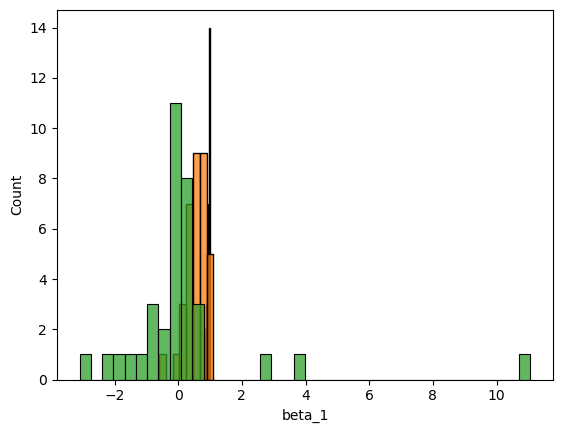

In [991]:
sns.histplot(x=out['beta_1'])
sns.histplot(x=out['beta_3'])
sns.histplot(x=out['beta_7'])

<AxesSubplot:xlabel='var_1', ylabel='Count'>

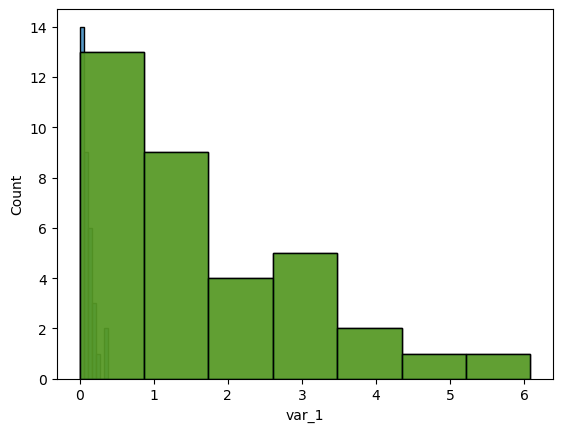

In [992]:
sns.histplot(x=out['var_1'])
sns.histplot(x=out['var_3'])
sns.histplot(x=out['var_7'])

In [993]:
out['taleb_pnl'].mean()

113.00542857142854

In [994]:
print(out['var_1'].mean())
print((out['var_3']* 10).mean())
print(out['var_7'].mean() * 500)

0.10109753130452002
16.85415372583487
842.7076862917432


In [995]:
print(out['var_1'].mean())
print(out['var_3'].mean())
print(out['var_7'].mean())

0.10109753130452002
1.6854153725834864
1.6854153725834864


In [996]:
out['taleb_pnl'].mean()

113.00542857142854

In [997]:
[i for i in out['taleb_pnl']]

[-76.31000000000002,
 -222.54000000000002,
 1280.3099999999997,
 0.0,
 -531.1099999999999,
 0.0,
 -205.51000000000005,
 0.0,
 -284.4200000000001,
 -76.30000000000001,
 0.0,
 168.95999999999992,
 1336.8699999999997,
 0.0,
 200.49,
 91.39999999999996,
 0.0,
 673.2599999999999,
 -412.27,
 497.67000000000013,
 0.0,
 0.0,
 0.0,
 -192.54999999999998,
 12.829999999999927,
 0.0,
 -21.360000000000085,
 511.6199999999999,
 513.0899999999999,
 -161.2,
 0.0,
 783.82,
 -198.20999999999998,
 0.0,
 266.65000000000003]

In [998]:
trade_df

count,created_time,no_price,no_price_dollars,price,taker_side,ticker,trade_id,yes_price,yes_price_dollars
i64,str,i64,str,f64,str,str,str,i64,str
5,"""2025-02-23T23:05:54.392803Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""18409088-460a-4b45-a0bf-a91b5a…",99,"""0.9900"""
25,"""2025-02-23T21:16:29.248296Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""01752953-f9da-480f-8976-1792d4…",99,"""0.9900"""
470,"""2025-02-23T21:08:53.212869Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""87df6e39-12a8-453e-b3f4-4aa5d4…",99,"""0.9900"""
50,"""2025-02-23T18:28:51.675307Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""49a99f80-e3ff-429e-b817-67c415…",99,"""0.9900"""
348,"""2025-02-23T17:43:41.41342Z""",6,"""0.0600""",0.94,"""yes""","""KXSPDPERCENT-25-17.45""","""5e64e796-5849-452d-b7aa-bf389f…",94,"""0.9400"""
…,…,…,…,…,…,…,…,…,…
73,"""2025-09-11T19:27:59.385288Z""",86,"""0.8600""",0.14,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""31741ca0-082d-49c9-8230-fe1ffd…",14,"""0.1400"""
85,"""2025-09-11T19:27:24.241001Z""",88,"""0.8800""",0.12,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""b20d214b-8677-45f0-a276-751769…",12,"""0.1200"""
100,"""2025-09-11T19:27:24.241001Z""",89,"""0.8900""",0.11,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""a723149a-7e6d-474e-b8e8-7a3a99…",11,"""0.1100"""


In [999]:
out = out.join(markets, on='ticker')

In [1000]:
out

ticker,beta_1,beta_3,beta_7,ljung_1,ljung_3,ljung_7,var_1,var_3,var_7,optional_sampling_mean,taleb_pnl,taleb_sharpe,trades,volume,settlement_value,status
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,str
"""KXSPDPERCENT-25-17.45""",0.90987,-0.600155,-1.784019,1.7794e-13,0.0,2.6223e-50,0.069238,3.279755,3.279755,0.182353,-21.36,-0.054632,4,21103,100,"""finalized"""
"""KXSPDPERCENT-25-12.45""",0.987562,0.254298,-0.145446,2.2269e-30,0.0,3.5012e-299,0.068169,1.338621,1.338621,0.007739,200.49,0.843396,3,26285,0,"""finalized"""
"""KXNYCMAYORDROUND-25-8""",0.935532,0.512183,-7.1816e-17,1.8738e-12,0.0,null,0.13529,0.543026,0.543026,0.040924,0.0,0.0,0,136437,0,"""finalized"""
"""KXNYCMAYORDROUND-25-7""",0.944421,0.412083,-0.044304,1.5312e-11,0.0,0.010887,0.141904,0.208478,0.208478,0.190387,0.0,0.0,0,147476,0,"""finalized"""
"""KXNYCMAYORDROUND-25-6""",0.895575,0.176313,0.047817,2.6065e-16,0.0,0.146918,0.185387,0.124847,0.124847,0.216511,0.0,0.0,0,174626,0,"""finalized"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""KXGOVTFUNDSVOTES-25MAR17-62.5""",0.970741,0.687292,0.280911,1.4903e-48,0.0,0.0,0.080209,0.387319,0.387319,-0.06558,-161.2,-0.499505,1,192006,0,"""finalized"""
"""KXGOVTFUNDSVOTES-25MAR17-53.0""",0.960894,0.437831,-1.091799,5.2360e-26,0.0,4.8247e-285,0.085006,4.268651,4.268651,0.020122,-192.55,-0.845437,2,65726,0,"""finalized"""
"""KXGOVTFUNDSVOTES-25MAR17-52.0""",0.916687,0.433348,-0.754794,1.3874e-38,0.0,4.4582e-67,0.132466,1.324525,1.324525,-0.039356,0.0,0.0,0,59006,0,"""finalized"""


<AxesSubplot:ylabel='Count'>

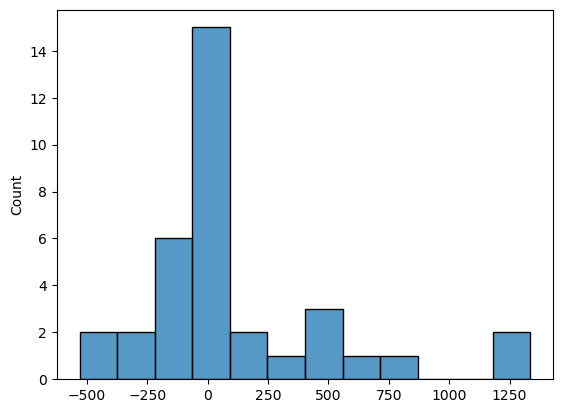

In [1001]:
sns.histplot(out['taleb_pnl'])

<AxesSubplot:xlabel='taleb_sharpe', ylabel='taleb_pnl'>

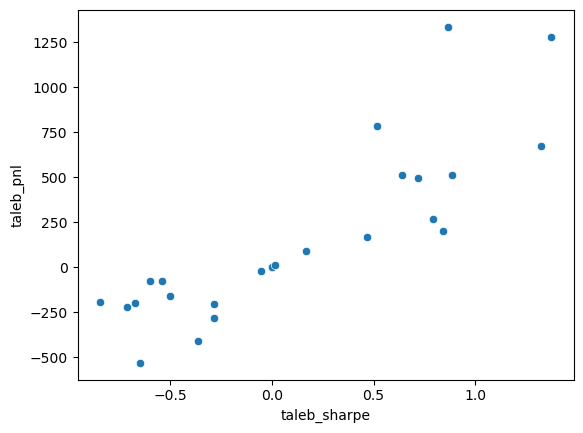

In [1002]:
from matplotlib import pyplot as plt
sns.scatterplot(x=out['taleb_sharpe'], y=out['taleb_pnl'])

In [1003]:
out.sort(by='trades')

ticker,beta_1,beta_3,beta_7,ljung_1,ljung_3,ljung_7,var_1,var_3,var_7,optional_sampling_mean,taleb_pnl,taleb_sharpe,trades,volume,settlement_value,status
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,str
"""KXNYCMAYORDROUND-25-8""",0.935532,0.512183,-7.1816e-17,1.8738e-12,0.0,null,0.13529,0.543026,0.543026,0.040924,0.0,0.0,0,136437,0,"""finalized"""
"""KXNYCMAYORDROUND-25-7""",0.944421,0.412083,-0.044304,1.5312e-11,0.0,0.010887,0.141904,0.208478,0.208478,0.190387,0.0,0.0,0,147476,0,"""finalized"""
"""KXNYCMAYORDROUND-25-6""",0.895575,0.176313,0.047817,2.6065e-16,0.0,0.146918,0.185387,0.124847,0.124847,0.216511,0.0,0.0,0,174626,0,"""finalized"""
"""KXNYCMAYORDROUND-25-5""",0.883115,0.29297,0.085201,6.8089e-15,0.0,3.2148e-129,0.129235,0.692651,0.692651,0.048446,0.0,0.0,0,320691,0,"""finalized"""
"""KXNYCMAYORDROUND-25-4""",0.803033,0.013657,-0.009714,1.4215e-14,0.0,7.2923e-258,0.137009,0.902368,0.902368,0.050049,0.0,0.0,0,215110,0,"""finalized"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""KXBOLIVIARUNOFFMOV-25OCT19-P7""",0.919145,0.589915,-0.089391,4.8090e-11,2.8955e-177,null,0.387471,1.567576,1.567576,-0.036234,1280.31,1.374258,13,90699,100,"""finalized"""
"""KXELECTIONMOVAZ7S-25SEP23-P42""",0.969337,0.351606,0.141877,0.000027,0.0,9.1595e-38,0.109076,1.140925,1.140925,-0.043253,12.83,0.016346,15,84045,0,"""finalized"""
"""KXELECTIONMOVAZ7S-25SEP23-P37""",0.939046,0.628816,0.451486,1.1157e-9,0.0,7.1913e-140,0.178217,2.952166,2.952166,0.08569,-531.11,-0.647502,18,75184,100,"""finalized"""


In [1011]:
out['volume'].median()

101048.0

In [1005]:
out['taleb_sharpe'].mean()

0.08861624547329935

In [1006]:
trade_df

count,created_time,no_price,no_price_dollars,price,taker_side,ticker,trade_id,yes_price,yes_price_dollars
i64,str,i64,str,f64,str,str,str,i64,str
5,"""2025-02-23T23:05:54.392803Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""18409088-460a-4b45-a0bf-a91b5a…",99,"""0.9900"""
25,"""2025-02-23T21:16:29.248296Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""01752953-f9da-480f-8976-1792d4…",99,"""0.9900"""
470,"""2025-02-23T21:08:53.212869Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""87df6e39-12a8-453e-b3f4-4aa5d4…",99,"""0.9900"""
50,"""2025-02-23T18:28:51.675307Z""",1,"""0.0100""",0.99,"""yes""","""KXSPDPERCENT-25-17.45""","""49a99f80-e3ff-429e-b817-67c415…",99,"""0.9900"""
348,"""2025-02-23T17:43:41.41342Z""",6,"""0.0600""",0.94,"""yes""","""KXSPDPERCENT-25-17.45""","""5e64e796-5849-452d-b7aa-bf389f…",94,"""0.9400"""
…,…,…,…,…,…,…,…,…,…
73,"""2025-09-11T19:27:59.385288Z""",86,"""0.8600""",0.14,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""31741ca0-082d-49c9-8230-fe1ffd…",14,"""0.1400"""
85,"""2025-09-11T19:27:24.241001Z""",88,"""0.8800""",0.12,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""b20d214b-8677-45f0-a276-751769…",12,"""0.1200"""
100,"""2025-09-11T19:27:24.241001Z""",89,"""0.8900""",0.11,"""yes""","""KXELECTIONMOVAZ7S-25SEP23-P37""","""a723149a-7e6d-474e-b8e8-7a3a99…",11,"""0.1100"""
